In [1]:
import warnings
warnings.filterwarnings("ignore")  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
import numpy as np
import pandas as pd
import random
import os
# from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn import preprocessing

from federated_utils import *

In [3]:
#declear path to your data
drebin_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/drebin.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/malgenome.csv'
kronodroid_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/kronodroid.csv'
TUANDROMD_data_path='/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/TUANDROMD.csv'



Drebin_data = pd.read_csv(drebin_data_path, header = None)

Malgenome_data = pd.read_csv(malgenome_data_path)

Tuandromd_data=pd.read_csv(TUANDROMD_data_path)

kronodroid_data=pd.read_csv(kronodroid_data_path)
Kronodroid_data = kronodroid_data.iloc[:,range(1,kronodroid_data.shape[1])]

In [11]:
n_clients = [5,10,15]
n_round = [10,20]

all_avg =[]

all_std =[]

dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


for d in range(0,len(dataset)):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))



            #==============================================
            # DW-FedAvg 2022
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)

            global_DWFed_Avg_index = np.ones((1,number_of_clients))/number_of_clients # [0.3 0.3 0.3]

            prev_local_model_test_performance = []

            current_local_model_test_performance = []

            beta= 0.2
            #-----------------------------------------------


            print('|=======================|')
            print('|   DWFedAvg  2022      |')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #============================================================    
                    # Custom Code added HERE for DWFedAvg
                    #============================================================
                    x_data = list()
                    y_data = list()
                    for local_i in clients_batched[client]:
                        for local_j in local_i[0].numpy():
                            x_data.append(local_j)
                        for local_k in local_i[1].numpy():
                            y_data.append(local_k[0])

                    x_data = np.array(x_data) #x_TRAIN for corresponding client
                    y_data = np.array(y_data) #y_TRAIN for corresponding client        

                    #============================================================

                    #fit local model with client's data
                    history = local_model.fit(x_data,y_data, epochs=32, verbose=0, validation_split=0.2)

                    current_local_model_test_performance.append(np.mean(history.history['val_accuracy'])) #saving local model test performmance



                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    K.clear_session()



                if comm_round ==0:
                    prev_local_model_test_performance = current_local_model_test_performance

                else:
                    for jj in range(0,len(prev_local_model_test_performance)):

                        #performance immproved
                        if (current_local_model_test_performance[jj]>prev_local_model_test_performance[jj]):
                            #print('YES')
                            global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] + global_DWFed_Avg_index[jj]*beta

                        #performance degraded
                        elif (current_local_model_test_performance[jj]<prev_local_model_test_performance[jj]):
                            #print('NO')
                            global_DWFed_Avg_index[jj] = global_DWFed_Avg_index[jj] - global_DWFed_Avg_index[jj]*beta


                            #print('NO CHANGE')

                    global_DWFed_Avg_index = global_DWFed_Avg_index / sum(global_DWFed_Avg_index) #Weight scaling


            #     print(global_DWFed_Avg_index)



                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list, global_DWFed_Avg_index)
                #print(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc, global_fpr = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc, global_fpr])



            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/DW-FedAvg-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)
            
            all_avg.append(np.concatenate(([dataset[d],r,cl],np.mean(all_results,axis=0)))) #Storing avg values for each dataset
            all_std.append(np.concatenate(([dataset[d],r,cl],np.std(all_results,axis=0)))) #Storing std values sfor each dataset
            

            
ALL_AVG = pd.DataFrame(all_avg, columns = ['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv('DW-FedAvg-all-avg-results.csv')

ALL_STD = pd.DataFrame(all_std, columns = ['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('DW-FedAvg-all-std-results.csv')


Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 98.005% | global_loss: 0.5767735838890076 | global_f1: 0.9728260869565218 | global_precision: 0.9772520473157416 | global_recall: 0.9684400360685302 | global_auc: 0.9957597159721956| flobal_FPR: 0.031559963931469794 
comm_round: 1 | global_acc: 98.138% | global_loss: 0.5660725235939026 | global_f1: 0.9745916515426496 | global_precision: 0.9808219178082191 | global_recall: 0.9684400360685302 | global_auc: 0.9959154621268562| flobal_FPR: 0.031559963931469794 
comm_round: 2 | global_acc: 98.138% | global_loss: 0.5650749206542969 | global_f1: 0.974660633484163 | global_precision: 0.9782016348773842 | global_recall: 0.9711451758340848 | global_auc: 0.9962245802569906| flobal_FPR: 0.028854824165915238 
comm_round: 3 | global_acc: 98.305% | g

|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 97.540% | global_loss: 0.5728867650032043 | global_f1: 0.9663330300272976 | global_precision: 0.9752066115702479 | global_recall: 0.957619477006312 | global_auc: 0.9951291339801547| flobal_FPR: 0.04238052299368801 
comm_round: 1 | global_acc: 98.105% | global_loss: 0.5644340515136719 | global_f1: 0.9741730856366108 | global_precision: 0.9790528233151184 | global_recall: 0.9693417493237151 | global_auc: 0.9959202104852299| flobal_FPR: 0.030658250676284943 
comm_round: 2 | global_acc: 98.238% | global_loss: 0.5633145570755005 | global_f1: 0.9759855006796557 | global_precision: 0.9808743169398907 | global_recall: 0.9711451758340848 | global_auc: 0.9961524052097088| flobal_FPR: 0.028854824165915238 
comm_round: 3 | global_acc: 98.371% | global_loss: 0.5628735423088074 | global_f1: 0.9777979157227006 | global_precision: 0.982695810564663 | global_recall: 0.9729486023444545 | global_auc:

comm_round: 13 | global_acc: 98.438% | global_loss: 0.5632355213165283 | global_f1: 0.9787618617261635 | global_precision: 0.9809782608695652 | global_recall: 0.9765554553651938 | global_auc: 0.9960009325775847| flobal_FPR: 0.023444544634806132 
comm_round: 14 | global_acc: 98.438% | global_loss: 0.5630442500114441 | global_f1: 0.9787618617261635 | global_precision: 0.9809782608695652 | global_recall: 0.9765554553651938 | global_auc: 0.9960066306076333| flobal_FPR: 0.023444544634806132 
comm_round: 15 | global_acc: 98.404% | global_loss: 0.5630682706832886 | global_f1: 0.9783001808318263 | global_precision: 0.9809610154125114 | global_recall: 0.975653742110009 | global_auc: 0.9959819391440894| flobal_FPR: 0.024346257889990983 
comm_round: 16 | global_acc: 98.471% | global_loss: 0.5630220174789429 | global_f1: 0.9792231255645889 | global_precision: 0.9809954751131221 | global_recall: 0.9774571686203787 | global_auc: 0.9959900113533249| flobal_FPR: 0.02254283137962128 
comm_round: 17 | g

comm_round: 4 | global_acc: 99.474% | global_loss: 0.5673812031745911 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9999383472437364| flobal_FPR: 0.003861003861003861 
comm_round: 5 | global_acc: 99.474% | global_loss: 0.5673826336860657 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9999383472437364| flobal_FPR: 0.003861003861003861 
comm_round: 6 | global_acc: 99.474% | global_loss: 0.5672230124473572 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9999383472437364| flobal_FPR: 0.003861003861003861 
comm_round: 7 | global_acc: 99.474% | global_loss: 0.5671660304069519 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9999460538382695| flobal_FPR: 0.003861003861003861 
comm_round: 8 | glob

comm_round: 6 | global_acc: 99.211% | global_loss: 0.5679078102111816 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9998844010820058| flobal_FPR: 0.003861003861003861 
comm_round: 7 | global_acc: 99.211% | global_loss: 0.5676650404930115 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9998921076765388| flobal_FPR: 0.003861003861003861 
comm_round: 8 | global_acc: 99.211% | global_loss: 0.5675886869430542 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9999075208656047| flobal_FPR: 0.003861003861003861 
comm_round: 9 | global_acc: 99.211% | global_loss: 0.5676138401031494 | global_f1: 0.9885057471264367 | global_precision: 0.9809885931558935 | global_recall: 0.9961389961389961 | global_auc: 0.9999152274601376| flobal_FPR: 0.003861003861003861 
comm_round: 10 | glo

comm_round: 19 | global_acc: 99.605% | global_loss: 0.5675280690193176 | global_f1: 0.9942196531791908 | global_precision: 0.9923076923076923 | global_recall: 0.9961389961389961 | global_auc: 0.9998766944874729| flobal_FPR: 0.003861003861003861 
---------------------------------------------
No. of Clients: 15
No. of Rounds: 20
---------------------------------------------
|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 97.500% | global_loss: 0.584335207939148 | global_f1: 0.9623762376237623 | global_precision: 0.9878048780487805 | global_recall: 0.9382239382239382 | global_auc: 0.9964703797039126| flobal_FPR: 0.06177606177606178 
comm_round: 1 | global_acc: 98.289% | global_loss: 0.5751559734344482 | global_f1: 0.974559686888454 | global_precision: 0.9880952380952381 | global_recall: 0.9613899613899614 | global_auc: 0.9983353755808846| flobal_FPR: 0.03861003861003861 
comm_round: 2 | global_acc: 98.684% | global_loss: 0.57291734

|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 94.401% | global_loss: 0.5420777797698975 | global_f1: 0.9467275494672756 | global_precision: 0.954573357888275 | global_recall: 0.9390096618357487 | global_auc: 0.9819353798989636| flobal_FPR: 0.06099033816425121 
comm_round: 1 | global_acc: 94.830% | global_loss: 0.5286742448806763 | global_f1: 0.9506353861192571 | global_precision: 0.9619188921859545 | global_recall: 0.9396135265700483 | global_auc: 0.9839021972523991| flobal_FPR: 0.06038647342995169 
comm_round: 2 | global_acc: 95.028% | global_loss: 0.5269127488136292 | global_f1: 0.9525206232813932 | global_precision: 0.9640074211502783 | global_recall: 0.941304347826087 | global_auc: 0.9848780617289796| flobal_FPR: 0.058695652173913045 
comm_round: 3 | global_acc: 95.143% | global_loss: 0.5260859131813049 | global_f1: 0.9535978480161399 | global_precision: 0.965581280178284 | global_recall: 0.9419082125603865 | global_auc: 0

comm_round: 12 | global_acc: 96.737% | global_loss: 0.5133282542228699 | global_f1: 0.9692028985507246 | global_precision: 0.9692028985507246 | global_recall: 0.9692028985507246 | global_auc: 0.9910321977915054| flobal_FPR: 0.030797101449275364 
comm_round: 13 | global_acc: 96.749% | global_loss: 0.5132156014442444 | global_f1: 0.9693310794494083 | global_precision: 0.969097054563013 | global_recall: 0.9695652173913043 | global_auc: 0.9911034978790771| flobal_FPR: 0.030434782608695653 
comm_round: 14 | global_acc: 96.820% | global_loss: 0.512894332408905 | global_f1: 0.9699643439898471 | global_precision: 0.9707269868150478 | global_recall: 0.9692028985507246 | global_auc: 0.9911143128762236| flobal_FPR: 0.030797101449275364 
comm_round: 15 | global_acc: 96.807% | global_loss: 0.51277095079422 | global_f1: 0.9698434761588204 | global_precision: 0.9706060239506471 | global_recall: 0.9690821256038648 | global_auc: 0.9911707135794289| flobal_FPR: 0.030917874396135265 
comm_round: 16 | glo

comm_round: 4 | global_acc: 95.598% | global_loss: 0.5223054885864258 | global_f1: 0.9580487804878048 | global_precision: 0.967487684729064 | global_recall: 0.9487922705314009 | global_auc: 0.9876093005030783| flobal_FPR: 0.051207729468599035 
comm_round: 5 | global_acc: 95.681% | global_loss: 0.5217002034187317 | global_f1: 0.9588339330365311 | global_precision: 0.9684612541579402 | global_recall: 0.9493961352657004 | global_auc: 0.9879956408000863| flobal_FPR: 0.050603864734299515 
comm_round: 6 | global_acc: 95.719% | global_loss: 0.5212726593017578 | global_f1: 0.9592147777845516 | global_precision: 0.9684845500430875 | global_recall: 0.9501207729468599 | global_auc: 0.9882175208213351| flobal_FPR: 0.049879227053140095 
comm_round: 7 | global_acc: 96.225% | global_loss: 0.521015465259552 | global_f1: 0.9641903374605487 | global_precision: 0.9691312835529526 | global_recall: 0.9592995169082126 | global_auc: 0.9884644495593793| flobal_FPR: 0.04070048309178744 
comm_round: 8 | global_

comm_round: 5 | global_acc: 99.104% | global_loss: 0.39212682843208313 | global_f1: 0.9944979367262723 | global_precision: 0.9958677685950413 | global_recall: 0.9931318681318682 | global_auc: 0.9989676989676989| flobal_FPR: 0.006868131868131868 
comm_round: 6 | global_acc: 99.104% | global_loss: 0.3918359875679016 | global_f1: 0.9944979367262723 | global_precision: 0.9958677685950413 | global_recall: 0.9931318681318682 | global_auc: 0.9989718614718615| flobal_FPR: 0.006868131868131868 
comm_round: 7 | global_acc: 99.104% | global_loss: 0.39150145649909973 | global_f1: 0.9944979367262723 | global_precision: 0.9958677685950413 | global_recall: 0.9931318681318682 | global_auc: 0.9990051615051615| flobal_FPR: 0.006868131868131868 
comm_round: 8 | global_acc: 99.104% | global_loss: 0.3913462162017822 | global_f1: 0.9944979367262723 | global_precision: 0.9958677685950413 | global_recall: 0.9931318681318682 | global_auc: 0.9991217116217116| flobal_FPR: 0.006868131868131868 
comm_round: 9 | gl

comm_round: 17 | global_acc: 98.992% | global_loss: 0.3898564577102661 | global_f1: 0.9938144329896906 | global_precision: 0.9944979367262724 | global_recall: 0.9931318681318682 | global_auc: 0.9976773226773227| flobal_FPR: 0.006868131868131868 
comm_round: 18 | global_acc: 98.992% | global_loss: 0.3898329734802246 | global_f1: 0.9938144329896906 | global_precision: 0.9944979367262724 | global_recall: 0.9931318681318682 | global_auc: 0.99760656010656| flobal_FPR: 0.006868131868131868 
comm_round: 19 | global_acc: 98.880% | global_loss: 0.3896233141422272 | global_f1: 0.9931224209078404 | global_precision: 0.9944903581267218 | global_recall: 0.9917582417582418 | global_auc: 0.9975316350316351| flobal_FPR: 0.008241758241758242 
---------------------------------------------
No. of Clients: 10
No. of Rounds: 20
---------------------------------------------
|=======================|
|   DWFedAvg  2022      |
|=======================|
comm_round: 0 | global_acc: 96.976% | global_loss: 0.4045

comm_round: 9 | global_acc: 98.544% | global_loss: 0.39248165488243103 | global_f1: 0.9910529938059187 | global_precision: 0.993103448275862 | global_recall: 0.989010989010989 | global_auc: 0.998505661005661| flobal_FPR: 0.01098901098901099 
comm_round: 10 | global_acc: 98.544% | global_loss: 0.3923287093639374 | global_f1: 0.9910529938059187 | global_precision: 0.993103448275862 | global_recall: 0.989010989010989 | global_auc: 0.998530636030636| flobal_FPR: 0.01098901098901099 
comm_round: 11 | global_acc: 98.656% | global_loss: 0.39234328269958496 | global_f1: 0.9917469050894085 | global_precision: 0.9931129476584022 | global_recall: 0.9903846153846154 | global_auc: 0.9985889110889111| flobal_FPR: 0.009615384615384616 
comm_round: 12 | global_acc: 98.656% | global_loss: 0.39229172468185425 | global_f1: 0.9917469050894085 | global_precision: 0.9931129476584022 | global_recall: 0.9903846153846154 | global_auc: 0.9986138861138861| flobal_FPR: 0.009615384615384616 
comm_round: 13 | globa

ValueError: 7 columns passed, passed data had 10 columns

In [12]:
ALL_AVG = pd.DataFrame(all_avg, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_AVG.to_csv('DW-FedAvg-all-avg-results.csv')

ALL_STD = pd.DataFrame(all_std, columns = ['Dataset','Rounds','no-clients','global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc', 'global_fpr'])
ALL_STD.to_csv('DW-FedAvg-all-std-results.csv')

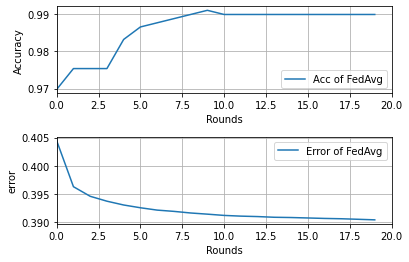

In [158]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()

